In [15]:
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import os
from torch import nn
from torchvision.models import vit_b_16


In [16]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## load the dataset 

In [17]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

# image_mean, image_std = processor.image_mean, processor.image_std
# height = processor.size["height"]
# width = processor.size["width"]
# size = (height, width)
# print("Size: ", size)
# print("Image mean: ", image_mean)
# print("Image std: ", image_std)

normalize = Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
_train_transforms = Compose(
        [
            Resize(256),
            transforms.CenterCrop(224), # 然后进行中心裁剪到模型期望的尺寸
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(256),
            transforms.CenterCrop(224), # 然后进行中心裁剪到模型期望的尺寸
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(image):
    return _train_transforms(image)
    # for item in examples:
        # item['pixel_values'] = _train_transforms(item['image'])
    # return examples

def val_transforms(examples):
    for item in examples:
        item['pixel_values'] = _val_transforms(item['image'])
    return examples

In [18]:
from five_dataset import MyDataset

In [19]:
# 2018-2021所有病人的数据
data_dir='/home/jialiangfan/DTViT/dataset2'
dataset=MyDataset(data_dir)
from torch.utils.data import random_split
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset = MyDataset(data_dir,test_frac=0.15,section="training")
# test_dataset=MyDataset(data_dir,test_frac=0.15,section="test")

In [8]:
train_dataloader = DataLoader(train_dataset,batch_size=8)


In [9]:
from models.transformer import DualVisionTransformer

model = DualVisionTransformer(
        image_size=224,
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        dropout=0.1,
        attention_dropout=0.1,
        num_classe1=2,
        num_classe2=4,
    )

for name, moudle in model.named_children():
    print(name)
    print(moudle)
    print('------------------')
# print(model.named_children)
# aa=nn.Sequential(*list(model.children())[:-1])

model.to(device)

conv_proj
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
------------------
encoder
Encoder(
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj):

DualVisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (se

In [10]:
type(model),type(model.encoder)

(models.transformer.DualVisionTransformer, models.transformer.Encoder)

In [21]:
import torch.optim as optim
criterion1 = nn.CrossEntropyLoss()  #(set loss function)
criterion2 = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
import time
num_epochs = 1   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0 #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, inputs in enumerate(train_dataloader):
        image=inputs['pixel_values']
        labels1=inputs['label1']
        labels2=inputs['label2']
        # move to GPU
        image = image.to(device)
        labels1 = labels1.to(device) 
        labels2 = labels2.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        pre_labels1,pre_labels2 = model(image)
        # print("pre_labels",pre_labels1,pre_labels2)
        _, preds1 = torch.max(pre_labels1, 1)
        _, preds2 = torch.max(pre_labels2, 1)
        # print("type",preds1.dtype,labels1.dtype)
        # print("preds",preds1,preds2)
        # print("labels",labels1,labels2)
        loss1 = criterion1(pre_labels1,labels1)
        loss2=criterion2(pre_labels2,labels2)
        # 两个分类loss之和
        loss=loss1+loss2
        # print("loss",loss)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * image.size(0)
        # print("size",pre_labels1.size(),labels1.size())
        # print("data",labels1.data)
        # 两个分类的正确数
        running_corrects += torch.sum(preds1 == labels1.data)
        running_corrects += torch.sum(preds2 == labels2.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / (len(train_dataset)*2) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    # """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for index, inputs  in enumerate(test_dataloader):
            image, labels1,labels2 = inputs['pixel_values'],inputs['label1'],inputs['label2']
            image = image.to(device)
            labels1= labels1.to(device)
            labels2= labels2.to(device)
            print("labels2",labels2)

            outputs1,outputs2 = model(image)
            _, preds1 = torch.max(outputs1, 1)
            _, preds2 = torch.max(outputs2, 1)

# 
            loss1 = criterion1(outputs1, labels1)
            loss2 = criterion2(outputs2, labels2)
            loss = loss1 + loss2
            running_loss += loss.item() * image.size(0)

            running_corrects += torch.sum(preds1 == labels1.data)
            running_corrects += torch.sum(preds2 == labels2.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / (2*len(test_dataset))* 100
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running


KeyboardInterrupt: 

In [ ]:
save_path = 'dataset2-50-vit_unfreeze_pretrained.pth'
torch.save(model.state_dict(), save_path)

## load the pretrained model

In [5]:
save_path = 'dataset2-50-vit_unfreeze_pretrained.pth'
from models.transformer import DualVisionTransformer
model = DualVisionTransformer(
        image_size=224,
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        dropout=0.1,
        attention_dropout=0.1,
        num_classe1=2,
        num_classe2=4,
    )




model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

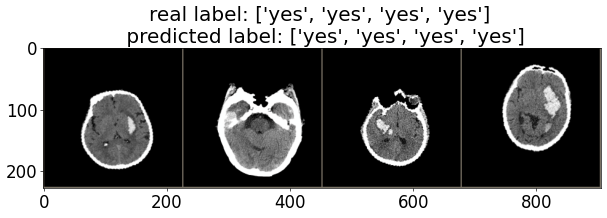

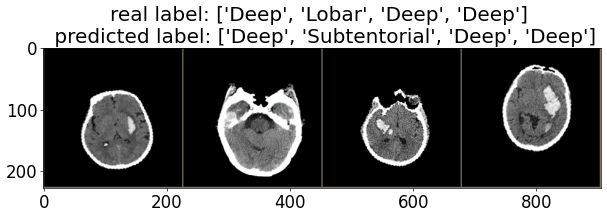

[Test] Loss: 0.2085 Acc: 96.2856% Time: 9.9038s


In [23]:
from plot_image import plot_image
import time
##Testing
test_dataloader = DataLoader(test_dataset,batch_size=8)

model.eval()
model.to(device)
start_time = time.time()
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for index, inputs  in enumerate(test_dataloader):
        image, labels1,labels2 = inputs['pixel_values'],inputs['label1'],inputs['label2']
        image = image.to(device)
        labels1= labels1.to(device)
        labels2= labels2.to(device)
        outputs1,outputs2  = model(image)
        _, preds1 = torch.max(outputs1, 1)
        _, preds2 = torch.max(outputs2, 1)
        loss1 = criterion1(outputs1, labels1)
        loss2 = criterion2(outputs2, labels2)
        loss = loss1 + loss2
        running_loss += loss.item() * image.size(0)
        running_corrects += torch.sum(preds1 == labels1.data)
        running_corrects += torch.sum(preds2 == labels2.data)
        if index == 0:
            plot_image(image, labels1, labels2, preds1, preds2)
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / (2* len(test_dataset)) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch_loss, epoch_acc, time.time() - start_time))